In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from phe import pickle, query, download, plot_summary

In [3]:
specimen_date = date_col
ltla = 'ltla'
msoa = 'msoa'
nation = 'nation'

In [8]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, specimen_date, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2020-12-23,2020-12-22,United Kingdom,K02000001,2258,NaN,142.0,453903.0
1,2020-12-23,2020-12-21,United Kingdom,K02000001,20214,NaN,377.0,423675.0
2,2020-12-23,2020-12-20,United Kingdom,K02000001,26285,NaN,345.0,433470.0
3,2020-12-23,2020-12-19,United Kingdom,K02000001,22940,2004.0,355.0,440584.0
4,2020-12-23,2020-12-18,United Kingdom,K02000001,35128,1880.0,398.0,390130.0
...,...,...,...,...,...,...,...,...
342,2020-12-23,2020-01-15,United Kingdom,K02000001,0,NaN,NaN,NaN
343,2020-12-23,2020-01-14,United Kingdom,K02000001,0,NaN,NaN,NaN
344,2020-12-23,2020-01-13,United Kingdom,K02000001,0,NaN,NaN,NaN
345,2020-12-23,2020-01-12,United Kingdom,K02000001,0,NaN,NaN,NaN


In [9]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England')

PosixPath('/Users/chris/Downloads/england_2020-12-23.csv')

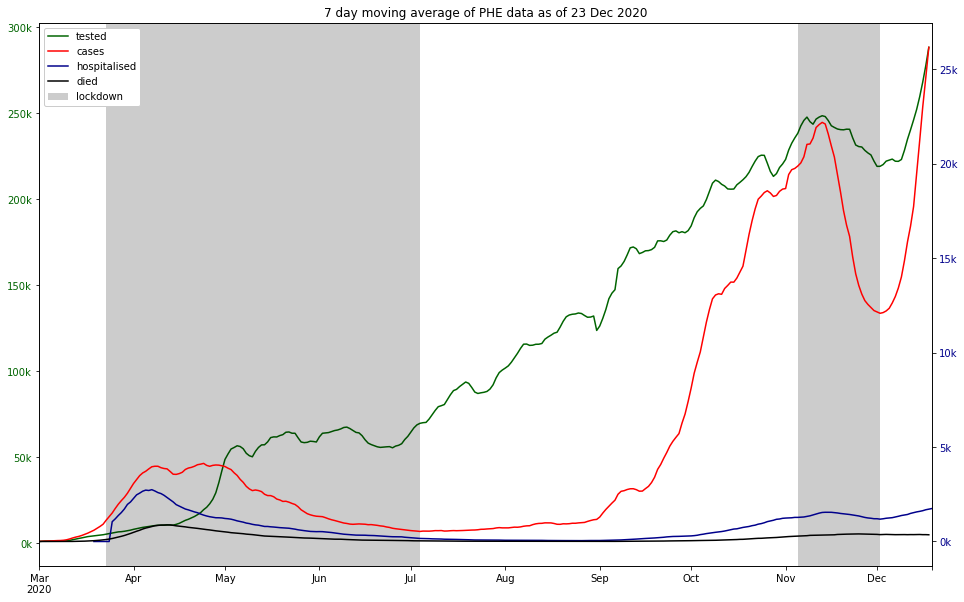

In [2]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [5]:
download(ltla, ltla, new_cases_by_specimen_date, new_deaths_by_death_date, unique_people_tested_sum,  new_cases_rate)

PosixPath('/Users/chris/Downloads/ltla_2020-12-23.csv')

In [12]:
download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change)

PosixPath('/Users/chris/Downloads/msoa_2020-12-23.csv')